# Signal Processing

The notebook goes into more detail on the processing of the 12 ECG data per patient. First, the signal itself is considered and then the ECG signal processing methods integrated in the 'wfdb' module are explored. Various approaches are then used to normalize the data and reduce noise in order to make the signals as comparable as possible.

In [4]:
from matplotlib import pyplot as plt
import wfdb.processing
import scipy.signal
import sys

sys.path.append('../scripts')
import data_helper

## Load Data

In [5]:
data = data_helper.load_data(only_demographic=False)

print("Number of patients per category:")
for cat_name in data.keys():
    print(f"{cat_name}: {len(data[cat_name])}")

Reading GSVT
Reading AFIB
Reading SR
Reading SB
Number of patients per category:
GSVT: 1027
AFIB: 9787
SR: 10426
SB: 15826


For a better understanding of the structure and dimensions of the individual data sets, there are printed.

In [6]:
# print keys of first record
print(f"Keys of first record of SB: {data['SB'][0].__dict__.keys()}")
print(data['SB'][0].__dict__)
print(data['SB'][0].__dict__['p_signal'].shape)

Keys of first record of SB: dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])
{'record_name': 'JS00002', 'n_sig': 12, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['Age: 59', 'Sex: Female', 'Dx: 426177001,164934002', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknown'], 'sig_name': ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.01 ,  0.01 ,  0.02 , ...,  0.054,  0.049,  0.   ],
       [-0.024, -0.02 ,  0.005, ...,  0.034,  0.034, -0.015],
       [-0.02 , -0.02 ,  0.   , ...,  0.034,  0.034, -0.01 ],
       ...,
       [ 0.015,  0.01 , -0.005, ..., -0.015, -0.02 ,  0.005],
    

In [7]:
# count how many different signals are available
counter_p = 0
counter_e_p = 0
counter_d = 0
counter_e_d = 0
for record in data['SR']:
    if record.p_signal is not None:
        counter_p += 1
    if record.e_p_signal is not None:
        counter_e_p += 1
    if record.d_signal is not None:
        counter_d += 1

print(f"Number of records with p_signal: {counter_p}")
print(f"Number of records with e_p_signal: {counter_e_p}")
print(f"Number of records with d_signal: {counter_d}")
print(f"Number of records with e_d_signal: {counter_e_d}")

Number of records with p_signal: 10426
Number of records with e_p_signal: 0
Number of records with d_signal: 0
Number of records with e_d_signal: 0


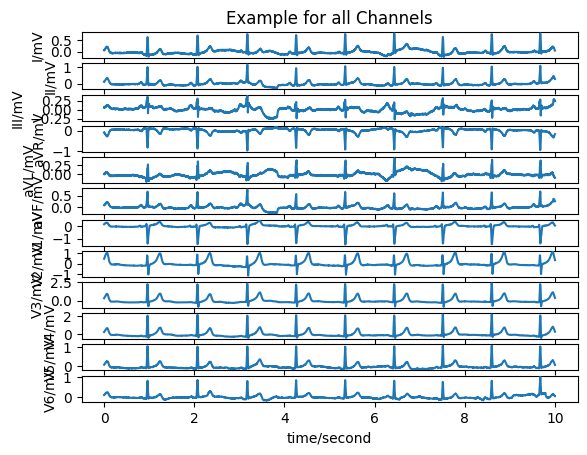

In [8]:
#Plot a complete Record
wfdb.plot_wfdb(data['SB'][24],title="Example for all Channels")

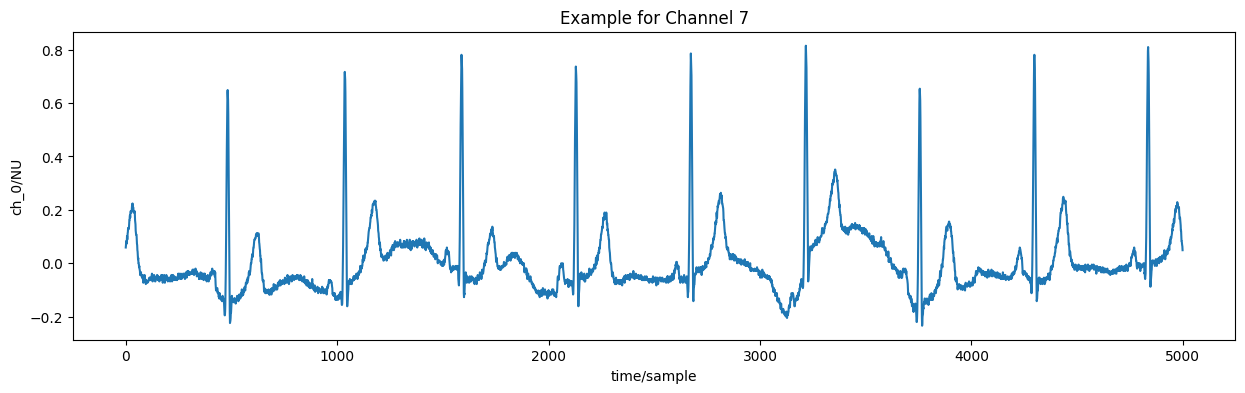

In [9]:
#Plot specific Channel of Record
fig = wfdb.plot_items(data['SB'][24].p_signal[:,0],title="Example for Channel 7",figsize=(15,4),return_fig=True)

In [10]:
#Find peaks in Channel 6 of Record 25
hard = wfdb.processing.find_local_peaks(data['SB'][24].p_signal[:,6],radius=3)
record = data['SB'][24].p_signal[:,6]
wholeRecord = data['SB'][24]
peak_points_y = [record[i] for i in hard] 

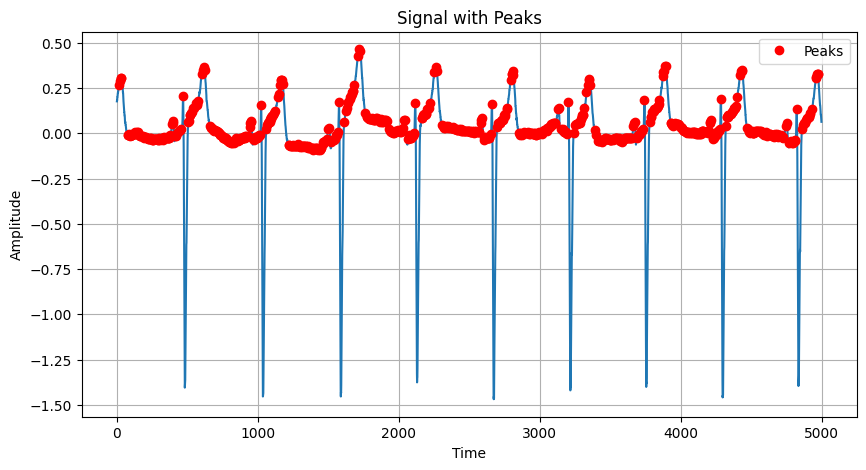

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
indicies = wfdb.processing.xqrs_detect(wholeRecord.p_signal[:,6],wholeRecord.fs,0,5000)
print(indicies)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 484 1038 1590 2131 2675 3219 3758 4300 4838]


In [13]:
# Normalization through upper and lower bounds (“Y-axis normalization”)
print("For normalization:   ", wholeRecord.p_signal[:,0])
wholeRecord.p_signal[:,0] = wfdb.processing.normalize_bound(wholeRecord.p_signal[:,0],0,1)
print("After normalization: ",wholeRecord.p_signal[:,0])



For normalization:    [0.059 0.068 0.083 ... 0.068 0.063 0.049]
After normalization:  [0.27931363 0.28789323 0.30219256 ... 0.28789323 0.28312679 0.26978074]


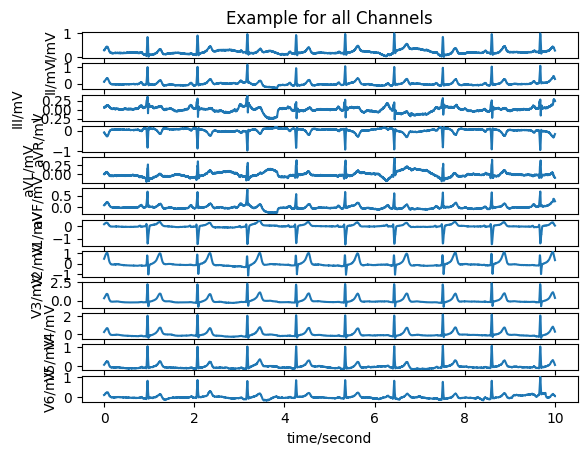

In [14]:
wfdb.plot_wfdb(wholeRecord,title="Example for all Channels")


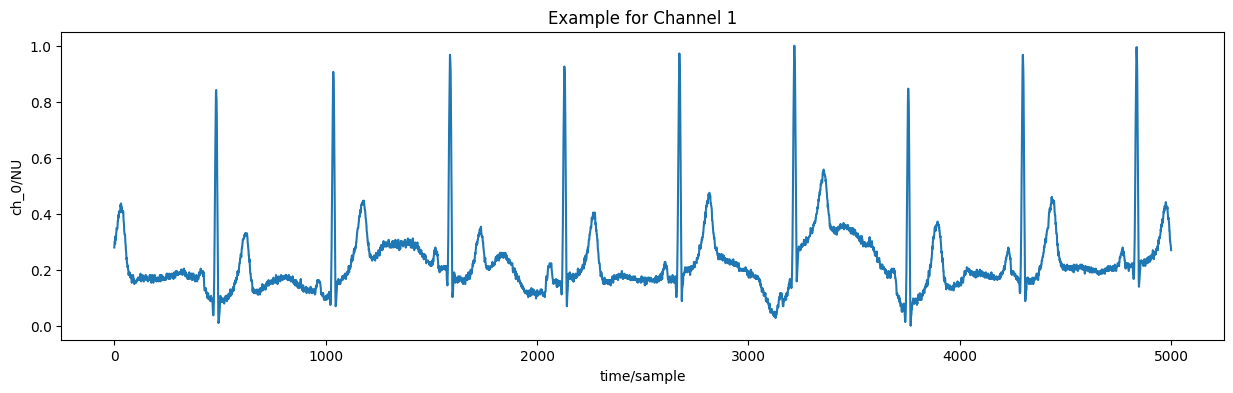

In [15]:
wfdb.plot_items(data['SB'][24].p_signal[:,0],title="Example for Channel 1",figsize=(15,4))

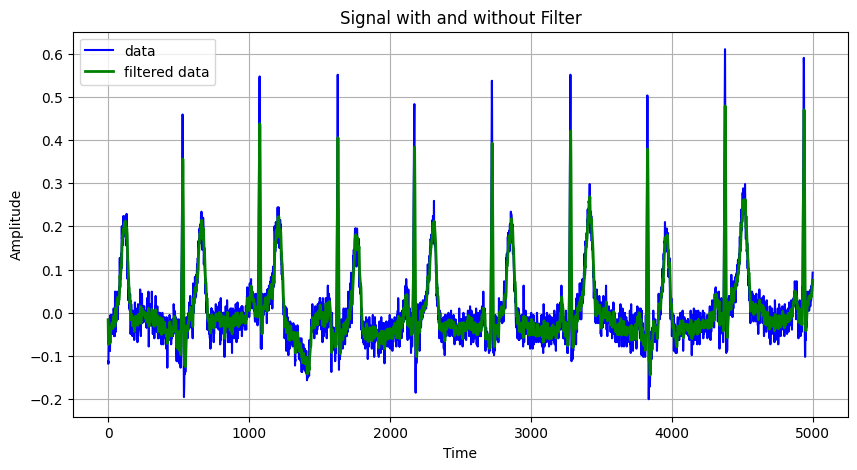

In [16]:
test_data = data['SB'][50].p_signal[:,0]


from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.

order = 1
fs = 500.0
cutoff = 25#25

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Apply filter to the signal
filtered_signal = butter_lowpass_filter(test_data, cutoff, fs, order)

# Plot the signal
plt.figure(figsize=(10, 5))
plt.plot(test_data, 'b-', label='data')
plt.plot(filtered_signal, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal with and without Filter')
plt.legend()
plt.grid(True)
plt.show()

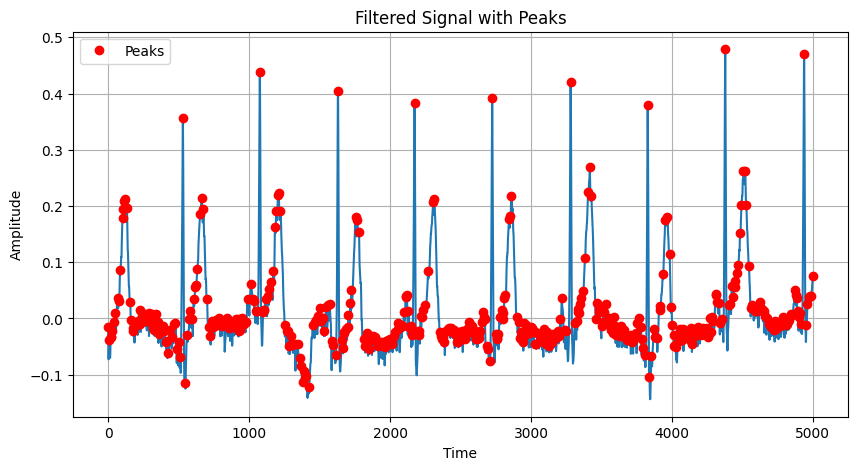

In [17]:
#Find peaks in Channel 6 of Record 25
hard = wfdb.processing.find_local_peaks(filtered_signal,radius=3)
record = filtered_signal
peak_points_y = [record[i] for i in hard] 

plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 530 1076 1631 2174 2725 3281 3828 4378 4938]


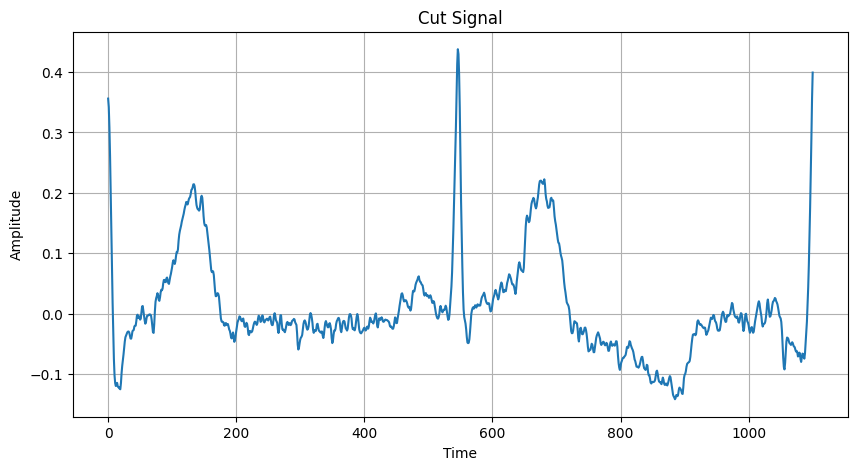

In [18]:
# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
indicies = wfdb.processing.xqrs_detect(filtered_signal,500,0,5000)
print(indicies)

# detected = [ 530 1076 1631 2174 2725 3281 3828 4378 4938]
cut_signal = filtered_signal[indicies[0]:indicies[2]]

# plot the cut signal
plt.figure(figsize=(10, 5))
plt.plot(cut_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal')
plt.grid(True)
plt.show()

1076
(array([15, 46], dtype=int64),)
[[1061 1092]]


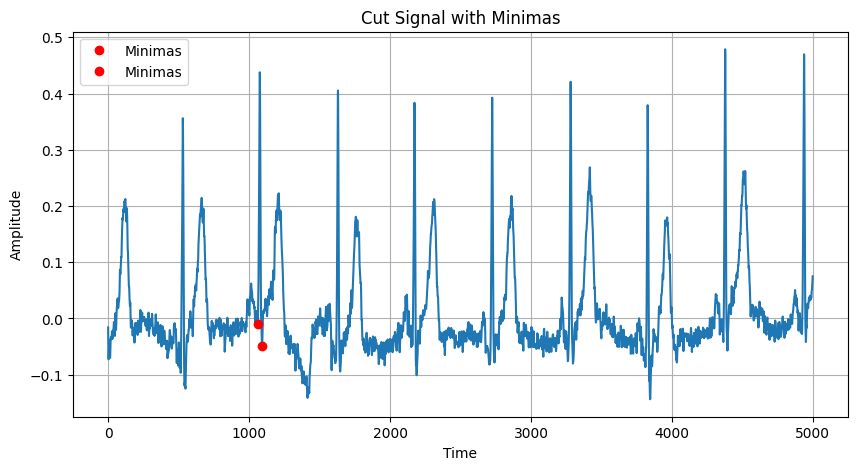

In [19]:
import numpy as np
# get the local minimas around the peaks
peak = indicies[1]
print(peak)
start_idx = 30
end_idx = 30
signal_section = filtered_signal[peak-start_idx:peak+end_idx]
minimas = scipy.signal.argrelextrema(signal_section, comparator=np.less, order=5)
print(minimas)
# map the minimas to the original signal
minimas = minimas + peak - start_idx
print(minimas)
minimas_y = [filtered_signal[i] for i in minimas]

# plot the cut signal with the minimas
plt.figure(figsize=(10, 5))
plt.plot(filtered_signal)
plt.plot(minimas, minimas_y, 'ro', label='Minimas')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal with Minimas')
plt.legend()
plt.grid(True)
plt.show()

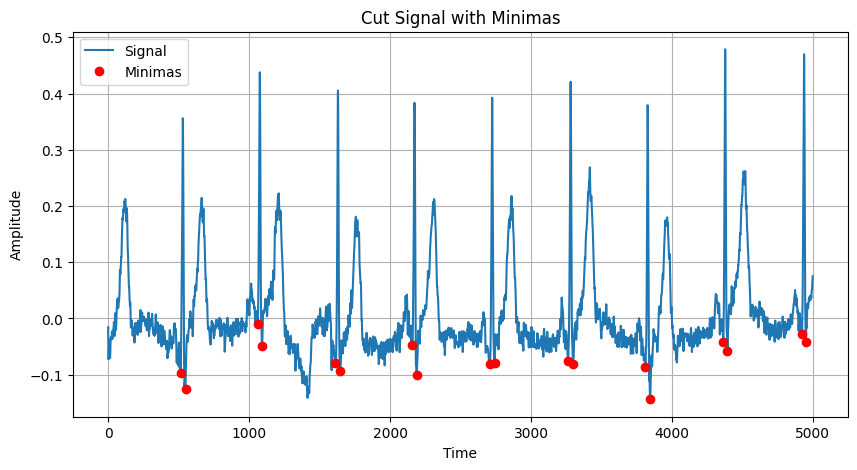

[-0.027759944001706754, -0.042024054853653535]


In [20]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal with Minimas')
plt.grid(True)

for peak in indicies:
    start_idx = 20
    end_idx = 25
    signal_section = filtered_signal[peak-start_idx:peak+end_idx]
    minimas = scipy.signal.argrelextrema(signal_section, comparator=np.less, order=5)
    
    # map the minimas to the original signal
    minimas = minimas[0] + peak - start_idx
    minimas_y = [filtered_signal[i] for i in minimas]
    # if minimas more than 2 take those with biggest difference in y
    if len(minimas) > 2:
        minimas_y = [filtered_signal[i] for i in minimas]
        minimas_y = sorted(minimas_y)
        minimas_y = minimas_y[:2]
        minimas = [minimas[i] for i in range(0,2)]

    # plot the minimas
    plt.plot(minimas, minimas_y, 'ro')

plt.legend(['Signal', 'Minimas'])
plt.show()

#print y values of minimas
print(minimas_y)

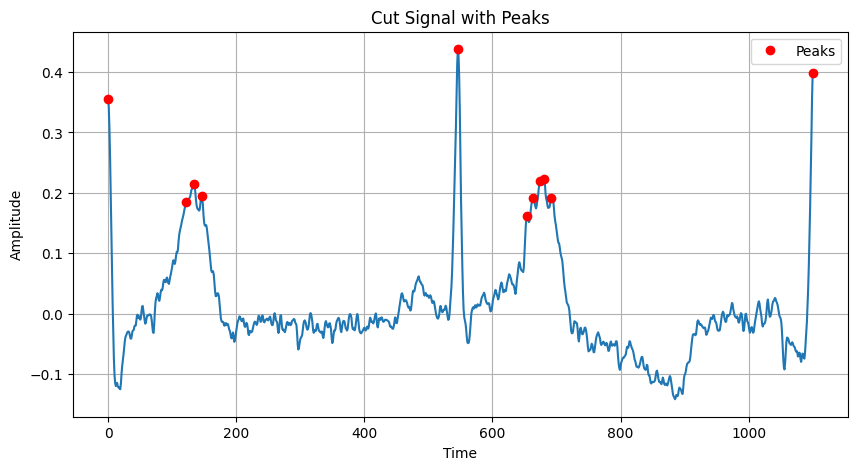

In [21]:
# find peaks in the cut signal
hard = wfdb.processing.find_local_peaks(cut_signal,radius=3)
#peak_points_y = [cut_signal[i] for i in hard]

tolerance = 1
# get standard deviation of the hard peaks
std = cut_signal[hard].std() * tolerance
# filter peaks with std
hard = [i for i in hard if cut_signal[i] > std]
# get the y values of the peaks
peak_points_y = [cut_signal[i] for i in hard]

plt.figure(figsize=(10, 5))
plt.plot(cut_signal)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()